Ekerö 341.180794416061 sek/capita 134.0
Knivsta 217.67038049190666 sek/capita 71.4
Markaryd 1604.9564813859956 sek/capita 19.7
Borgholm 1535.2518786264625 sek/capita 16.0
Svalöv 362.49065693430657 sek/capita 37.4
Malmö 1404.4706590225687 sek/capita 2277.0
Dals-Ed 1416.325669642857 sek/capita 6.4
Karlsborg 1629.9025504938818 sek/capita 17.4
Gullspång 1450.1848942598187 sek/capita 16.5
Bengtsfors 1444.6974543816175 sek/capita 10.5
Åmål 1796.252666609779 sek/capita 25.4
Skara 1400.2462699077955 sek/capita 43.8
Munkfors 1539.7876480541456 sek/capita 26.1
Grums 1788.6227848101266 sek/capita 23.6
Filipstad 1470.7698090207232 sek/capita 6.7
Fagersta 1808.439471407221 sek/capita 49.6
Orsa 1444.5954381752701 sek/capita 4.0
Ockelbo 1616.6730288976098 sek/capita 5.5
Krokom 374.59672064503013 sek/capita 2.5
Bjurholm 1465.5822616407982 sek/capita 1.8
Arvidsjaur 1562.0885363357215 sek/capita 1.1
Vallentuna 8553187.5 97.4
Österåker 6566326.571428572 157.3
Värmdö 9686567.2 104.6
Järfälla 8223620.0 158

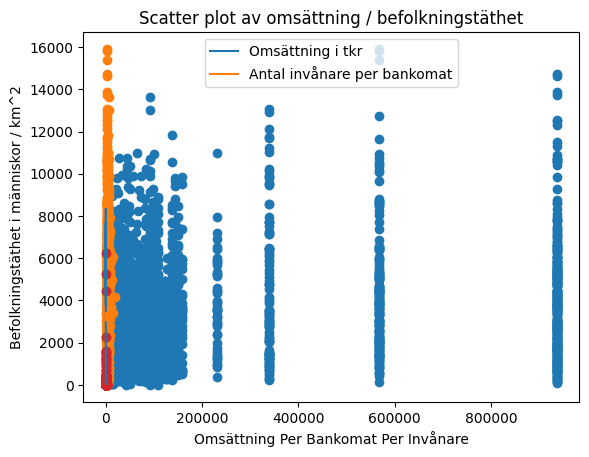

In [1]:
from collections import defaultdict
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from random import randint
from data_parsing import DataParser
from analysis_models import AnalysModeller
from bankomat import Bankomat

data = DataParser()
data.laddaKommuner()
data.laddaBankomater()
analyser = AnalysModeller(data)


analyser.slumpmässigBankomatOmsättning()
analyser.scatterPlotOmsättningPerInvånare()
analyser.scatterPlotOmsättningPerInvånarePerBankomat()
analyser.scatterPlotOmsättningPerInvånareMotBefolkningstäthet()
analyser.scatterPlotOmsättningPerAutomatMotBefolkningstäthet()

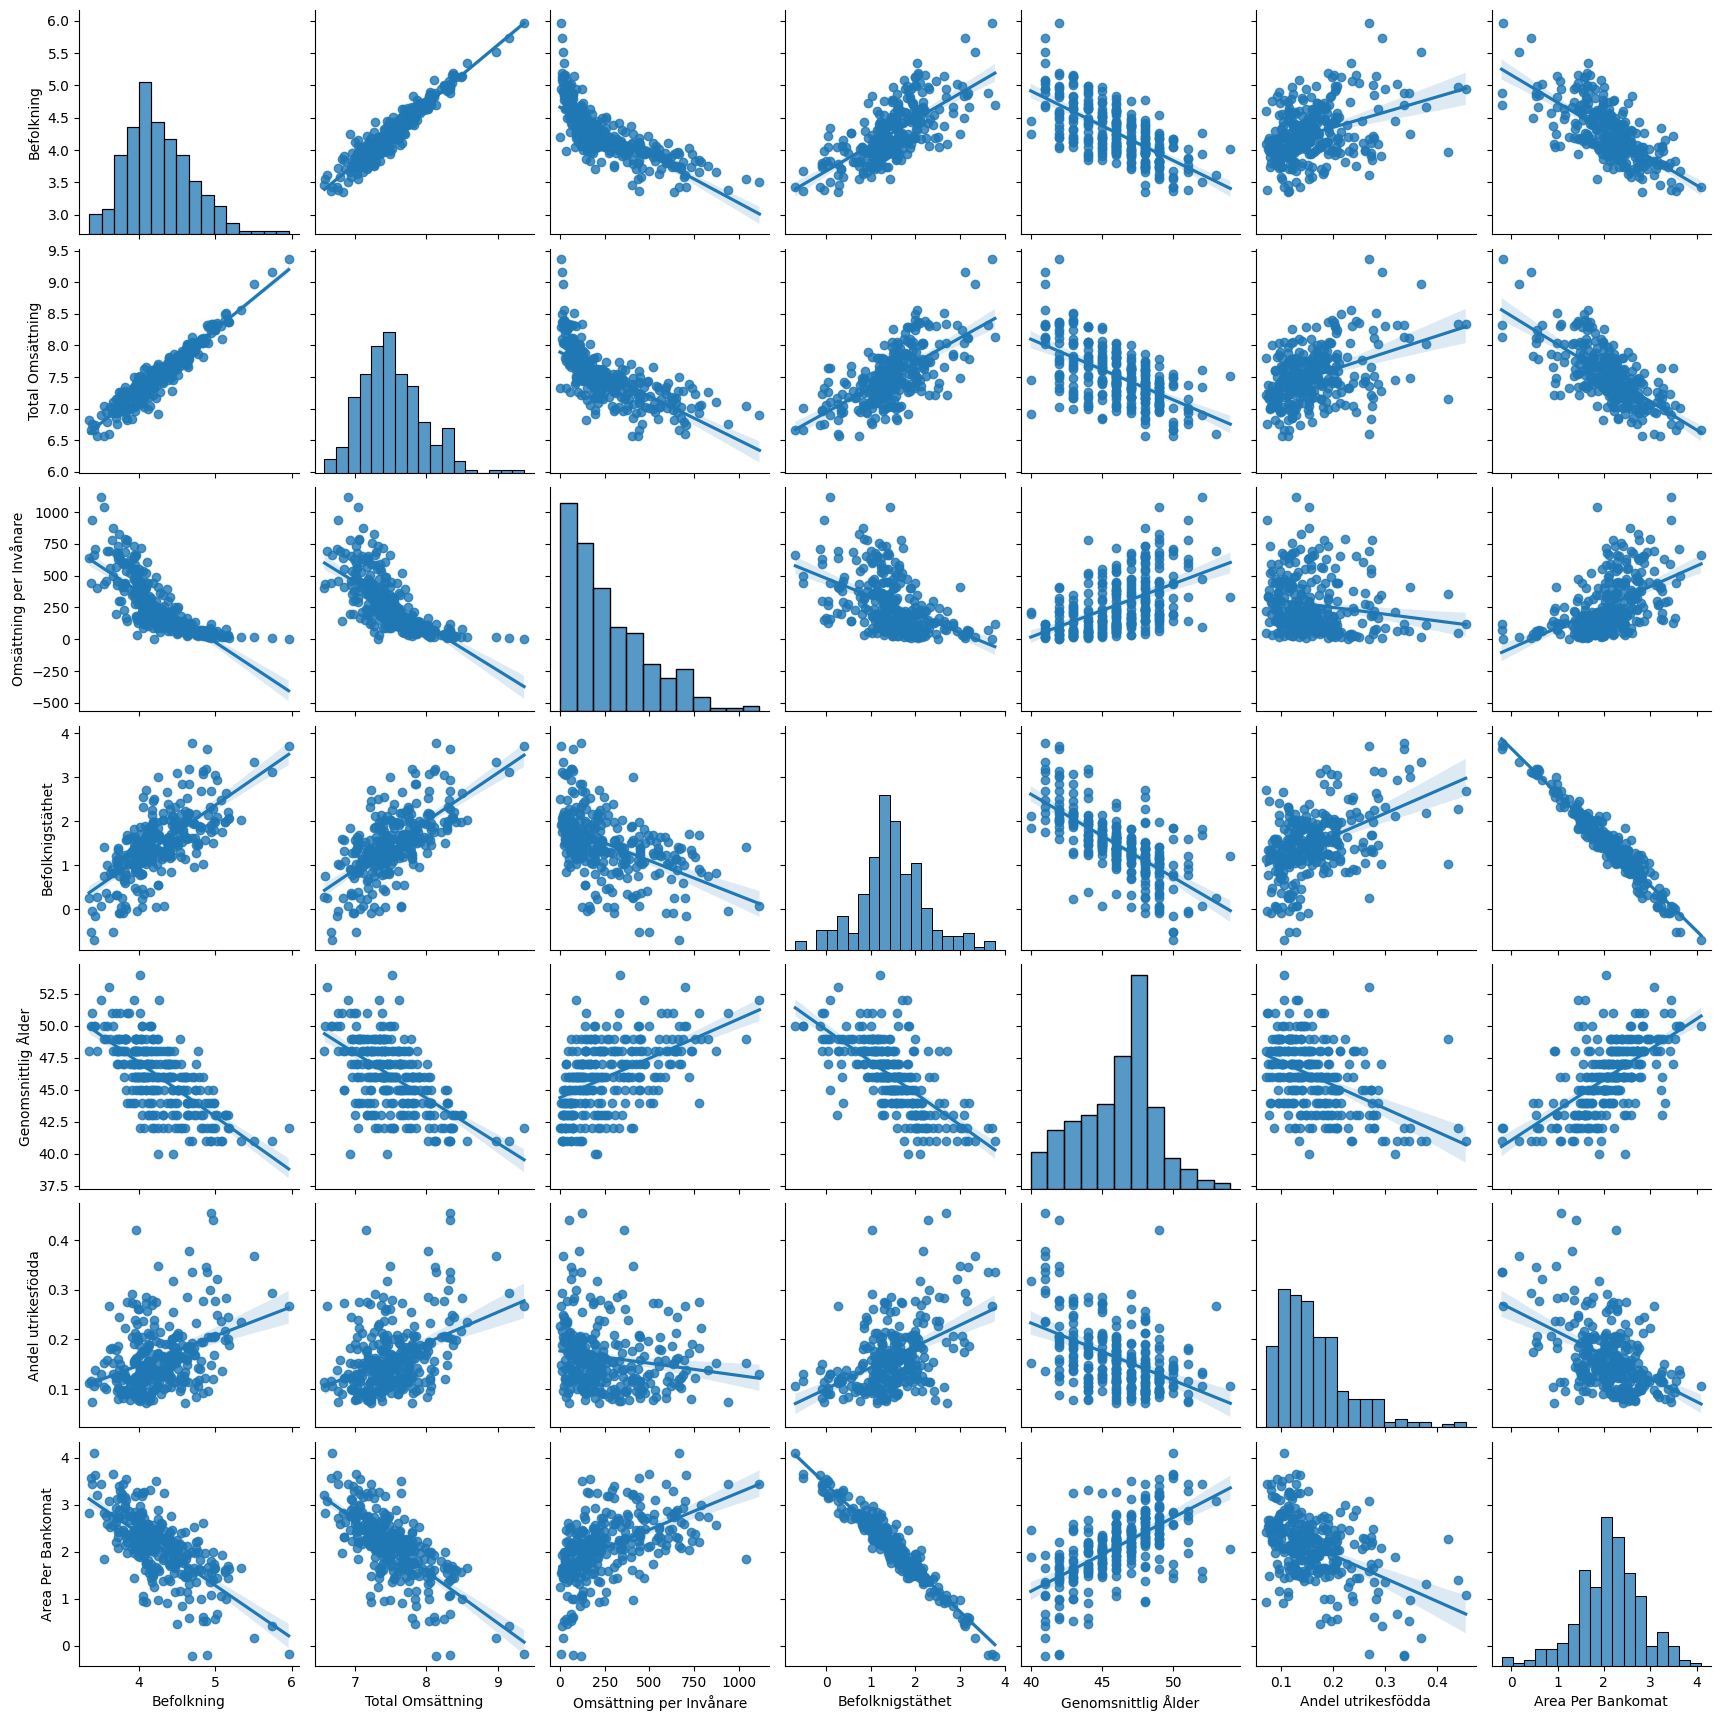

In [15]:
def dataframe(month):
    year = int(month[0:4])
    dataDict = defaultdict(dict)

    for kommun in data.kommuner:
        try:
            namn = kommun.namn
            befolkning = kommun.data[month]["total"]
            totalOmsättning = kommun.totalOmsättning
            bankomaterMedSEK = [bankomat for bankomat in data.bankomater if bankomat.transaktionsDataSEK]
            öppnaBankomaterIKommunen = [
                bankomat for bankomat in bankomaterMedSEK
                if (int(bankomat.transaktionsDataSEK[-1]["månad"][0:4]) > year 
                    or (int(bankomat.transaktionsDataSEK[-1]["månad"][0:4]) == year 
                        and int(bankomat.transaktionsDataSEK[-1]["månad"][5:]) > int(month[5:]))) 
                        and bankomat.geographicalData["kommun"] == kommun.namn]
            omsättningPerInvånare = sum([[transaktionsData["omsättning"] 
                                            for transaktionsData 
                                            in bankomat.transaktionsDataSEK 
                                            if transaktionsData["månad"] == month] 
                                            for bankomat 
                                            in öppnaBankomaterIKommunen][0]) / kommun.data[month]["total"]
            antalBankomater = kommun.antalBankomater
            befolkningstäthet = kommun.befolkningstätheter[year]
            snittÅlder = kommun.snittÅlder
            antalInvånarePerBankomat = befolkning / kommun.antalBankomater
            utrikesFödda = kommun.utrikesfödda[year]
            andelUtrikesfödda = utrikesFödda / befolkning
            bankomatTäthet = kommun.bankomatTäthet
            dataDict[namn] = {
                "Befolkning": np.log10(float(befolkning)),
                "Total Omsättning": np.log10(float(totalOmsättning)),
                "Omsättning per Invånare": omsättningPerInvånare,
                "Befolknigstäthet": np.log10(float(befolkningstäthet)),
                "Genomsnittlig Ålder": snittÅlder,
                "Andel utrikesfödda": andelUtrikesfödda,
                "Area Per Bankomat": np.log10(float(bankomatTäthet)),
            }
        except: 
            pass

    daf = pd.DataFrame(dataDict)

    return daf


df = dataframe("2020M07")
index = 0
"""for month in data.kommuner[0].data.keys():
    
    if month != "total" and month != "2014M01": 
        new_df = dataframe(month)
        df = pd.concat([df, new_df], axis=1)
"""
df = df.T
seaborn = sns
seaborn.pairplot(data=df, kind="reg")
plt.show()

                               OLS Regression Results                              
Dep. Variable:     Omsättning per Invånare   R-squared:                       0.634
Model:                                 OLS   Adj. R-squared:                  0.628
Method:                      Least Squares   F-statistic:                     98.25
Date:                     Sun, 21 May 2023   Prob (F-statistic):           9.22e-60
Time:                             23:25:26   Log-Likelihood:                -1824.1
No. Observations:                      289   AIC:                             3660.
Df Residuals:                          283   BIC:                             3682.
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

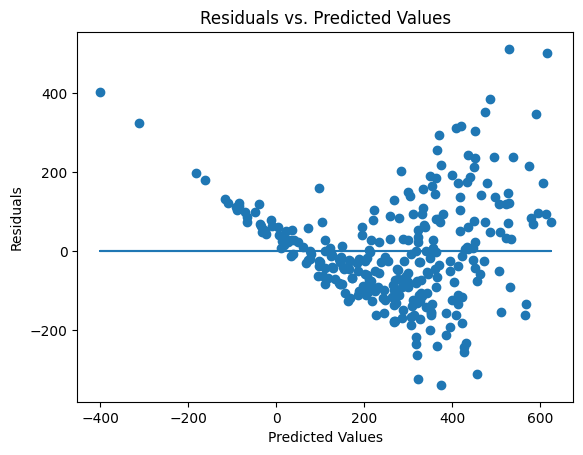

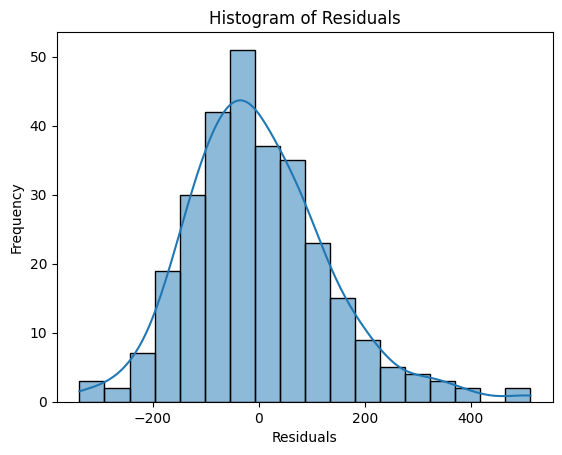

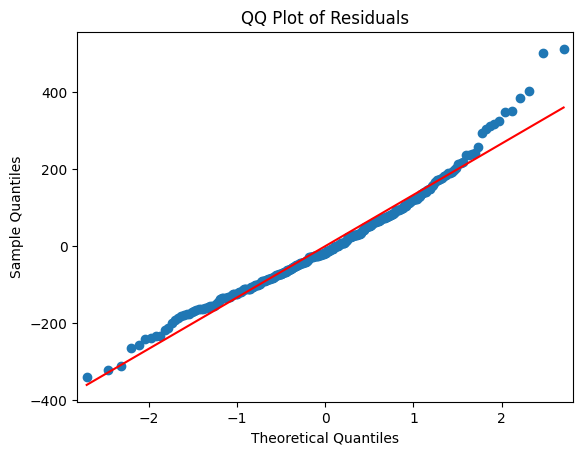

In [26]:
import statsmodels.api as sm
X = df[['Befolkning', 'Genomsnittlig Ålder', 'Area Per Bankomat','Andel utrikesfödda', 'Befolknigstäthet']]
Y = df['Omsättning per Invånare']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print(model.summary())

residuals = model.resid
plt.scatter(model.predict(), model.resid)
plt.plot(model.predict(), [0 for i in range(len(df))])
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

sm.qqplot(residuals, line='s')
plt.title('QQ Plot of Residuals')
plt.show()

residuals_df = pd.DataFrame({'Residuals': residuals})
average_df = residuals_df.groupby(level=0)['Residuals'].mean().reset_index()

In [34]:
import plotly.express as px
import plotly.graph_objs as go
import geopandas as gpd
import matplotlib.pyplot as plt

sweden = gpd.read_file("swedish_municipalities.geojson")

merged = sweden.merge(average_df, left_on='kom_namn', right_on='index')

lukas = "Residuals"
fig = px.choropleth_mapbox(merged,
                           geojson=merged.geometry,
                           locations=merged.index,
                           color= lukas,
                           color_continuous_scale='OrRd',
                           opacity=0.8,
                           mapbox_style='carto-positron',
                           center={'lat': 63.0, 'lon': 16.0},
                           zoom=4,
                           hover_name='kom_namn',
                           height=800,
                           width=500)

fig.update_layout(title= 'Residualer för multivariabel regression i svenska kommuner', title_font_size=24, margin=dict(l=0, r=0, t=50, b=0))

fig.show()

fig.write_image("Residualer.jpg", "jpg")

ValueError: 
Cannot infer image type from output path 'jpg'.
Please add a file extension or specify the type using the format parameter.
For example:

    >>> import plotly.io as pio
    >>> pio.write_image(fig, file_path, format='png')
